---

**Load essential libraries**

---

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 4.0) # set default size of plots

from sklearn.preprocessing import StandardScaler, RobustScaler

from scipy.sparse import random
from scipy import stats

---

Mount Google drive folder if running in Colab

---

In [2]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    # Change path below starting from /content/drive/MyDrive/Colab Notebooks/
    # depending on how data is organized inside your Colab Notebooks folder in
    # Google Drive
    DIR = '/content/drive/MyDrive/Colab Notebooks/ALA'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = 'Data/'

Mounted at /content/drive


---

Load ECG data

---

In [ ]:
# Load ECG data
FILE = DATA_DIR + 'ecg_missing.txt'
df_ecg = pd.read_csv(FILE, header = None, names = ['ecgvalues'])
print(df_ecg.head())
print(df_ecg['ecgvalues'].dtypes)
df_ecg['ecgvalues'] = df_ecg['ecgvalues'].astype(float)
print(df_ecg['ecgvalues'].dtypes)

          ecgvalues
0    -1.4374358e-02
1               NaN
2    -1.2637355e-02
3               NaN
4    -1.0812403e-02
object
float64


---

Check if there are any missing values

---

In [ ]:
# Check if there are any missing values
np.mean(df_ecg['ecgvalues'].isnull())*100

50.0

---

Component plot of the ecg signal

---

Text(0.5, 1.0, 'ECG Signal With Missing Values')

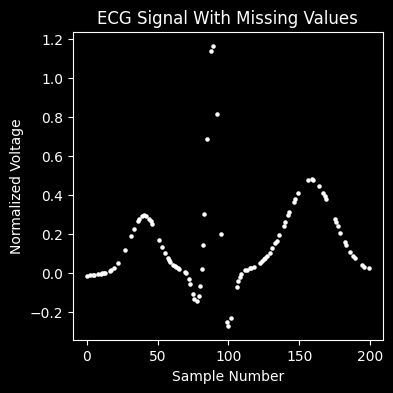

In [ ]:
# Component plot of the ecg signal
fig, ax = plt.subplots(1, 1)
component_index = range(0, len(df_ecg['ecgvalues']))
ax.scatter(component_index, df_ecg['ecgvalues'], color = 'white', marker = 'o', s = 5)
ax.set_xlabel('Sample Number')
ax.set_ylabel('Normalized Voltage')
ax.set_title('ECG Signal With Missing Values')

---

Extract the indices corresponding to the missing and known ECG values. For simplicity, assume that the full ECG signal is a 6-vector x with samples 3, 5, and 6 missing as shown below:

$$\begin{align*}
\mathbf{x} &= \begin{bmatrix}x_1\\x_2\\{\color{yellow}{x_3}}\\x_4\\{\color{yellow}{x_5}}\\{\color{yellow}{x_6}}\end{bmatrix} = \begin{bmatrix}x_1\\x_2\\{\color{yellow}{v_1}}\\x_4\\{\color{yellow}{v_2}}\\{\color{yellow}{v_3}}\end{bmatrix}.
\end{align*}$$

---

In [ ]:
# Extract the indices corresponding to the missing ECG values
indices_unknown = df_ecg[df_ecg.isnull()['ecgvalues']].index
print(indices_unknown)
# Extract the indices corresponding to the known ECG values
indices_known = df_ecg[~df_ecg.isnull()['ecgvalues']].index
print(indices_known)
indices_known=indices_known.values

Index([  1,   3,   6,   7,   9,  14,  15,  18,  20,  21,  23,  24,  25,  26,
        28,  29,  30,  32,  34,  35,  38,  41,  43,  47,  48,  49,  50,  52,
        54,  56,  60,  66,  67,  68,  71,  74,  77,  84,  86,  87,  90,  91,
        93,  94,  96,  97,  98, 101, 103, 104, 105, 110, 111, 114, 117, 119,
       120, 121, 123, 128, 130, 132, 135, 137, 138, 141, 144, 145, 148, 150,
       151, 152, 153, 154, 155, 157, 158, 161, 162, 163, 165, 166, 170, 171,
       172, 173, 174, 178, 180, 181, 184, 185, 187, 190, 191, 192, 193, 195,
       197, 198],
      dtype='int64')
Index([  0,   2,   4,   5,   8,  10,  11,  12,  13,  16,  17,  19,  22,  27,
        31,  33,  36,  37,  39,  40,  42,  44,  45,  46,  51,  53,  55,  57,
        58,  59,  61,  62,  63,  64,  65,  69,  70,  72,  73,  75,  76,  78,
        79,  80,  81,  82,  83,  85,  88,  89,  92,  95,  99, 100, 102, 106,
       107, 108, 109, 112, 113, 115, 116, 118, 122, 124, 125, 126, 127, 129,
       131, 133, 134, 136, 139, 140, 

---

Build a vector of known ecg_signal values. Using the simple ECG signal example, we get:

$$\mathbf{x}_\text{known} = \begin{bmatrix}x_1\\x_2\\x_4\end{bmatrix}.$$

---

In [ ]:
## Build a vector of known ecg_signal values
x_known = df_ecg.loc[indices_known,'ecgvalues']
print(x_known)

0     -0.014374
2     -0.012637
4     -0.010812
5     -0.009853
8     -0.006548
         ...   
188    0.085758
189    0.076497
194    0.042017
196    0.033077
199    0.023651
Name: ecgvalues, Length: 100, dtype: float64


---

Build the sampling matrices $\mathbf{S}_1$ and $\mathbf{S}_2$ such that

$$\begin{align*}
\underbrace{\begin{bmatrix}?&?&?\\?&?&?\\?&?&?\\?&?&?\\?&?&?\\?&?&?\end{bmatrix}}_{\mathbf{S}_1}\begin{bmatrix}x_1\\x_2\\x_4\end{bmatrix}+\underbrace{\begin{bmatrix}?&?&?\\?&?&?\\?&?&?\\?&?&?\\?&?&?\\?&?&?\end{bmatrix}}_{\mathbf{S}_2}\begin{bmatrix}{\color{yellow}{v_1}}\\{\color{yellow}{v_2}}\\{\color{yellow}{v_3}}\end{bmatrix}=\begin{bmatrix}x_1\\x_2\\{\color{yellow}{v_1}}\\x_4\\{\color{yellow}{v_2}}\\{\color{yellow}{v_3}}\end{bmatrix}.
\end{align*}$$

---

In [ ]:
I = np.eye(len(df_ecg))
S1 = I[:,indices_known]
S2 = I[:,indices_unknown]

---

Build the second-difference matrix $\mathbf{D}$ which for the simple ECG example is

$$\mathbf{D} = \begin{bmatrix}1&-2&1&0&0&0\\0&1&-2&1&0&0\\0&0&1&-2&1&0\\0&0&0&1&-2&1\end{bmatrix}.$$

---

In [ ]:
## Build the second-difference matrix D
n = len(df_ecg) # size of the signal
a = 1*np.ones(n-1)
b = -2*np.ones(n)
D = np.diag(a,-1) + np.diag(b,0) + np.diag(a,1)
D = D[1:-1, :]
D.shape


(198, 200)

---

Reconstruct the ECG signal such that it is smooth by solving the following linear least squares problem:

$$\begin{align*}\min_{\color{yellow}{\mathbf{v}}}\left\lVert\mathbf{D}\hat{\mathbf{x}}\right\rVert_2^2 = \min_{\color{yellow}{\mathbf{v}}}\left\lVert\mathbf{D}\left(\mathbf{S}_1\mathbf{x}_\text{known} + \mathbf{S}_2{\color{yellow}{\mathbf{v}}}\right)\right\rVert_2^2 = \min_\mathbf{v}\left\lVert\mathbf{D}\mathbf{S}_1\mathbf{x}_\text{known} + \mathbf{D}\mathbf{S}_2{\color{yellow}{\mathbf{v}}}\right\rVert_2^2.\end{align*}$$

---

In [ ]:
## Reconstruct the ECG signal such that it is smooth
A = np.dot(D, S2)
b = -np.dot(D, np.dot(S1,x_known))
v = linalg.lstsq(A, b)
#print(v[0].flatten().shape)
df_ecg.loc[indices_unknown, 'ecgvalues'] =  v[0].flatten()

In [ ]:
# Check if there are any missing values
np.sum(df_ecg['ecgvalues'].isnull())

0

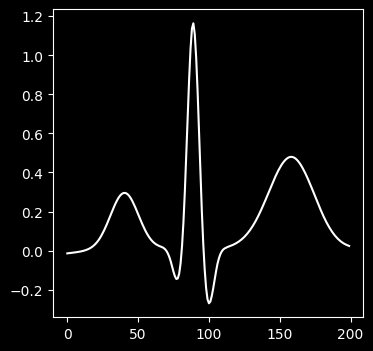

In [ ]:
# Component plot of the reconstructed ecg signal
fig, ax = plt.subplots(1, 1)
component_index = range(0, len(df_ecg['ecgvalues']))
ax.plot(component_index, df_ecg['ecgvalues'], color = 'white')